In [117]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE

In [118]:
# Define transformations
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.0,), (0.1,))])

# Download and load MNIST dataset using torchvision
train_dataset = torchvision.datasets.MNIST(
    root='../datasets', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(
    root='../datasets', train=False, download=True, transform=transform)

In [119]:
# Flatten the images for sklearn MLP
X_train = train_dataset.data.float().reshape(len(train_dataset), -1)
y_train = train_dataset.targets
X_test = test_dataset.data.float().reshape(len(test_dataset), -1)
y_test = test_dataset.targets

In [120]:
# Standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = torch.from_numpy(scaler.fit_transform(X_train))
X_test_scaled = torch.from_numpy(scaler.transform(X_test))

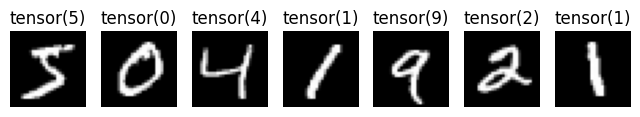

In [121]:
# Plot few images
fig, axs = plt.subplots(1, 7, figsize=(8, 10))
for i in range(7):
    axs[i].imshow(X_train[i].reshape((28, 28)), cmap='gray')
    axs[i].set_title(y_train[i])
    axs[i].axis('off')

In [122]:
# MLP model
class MLP(nn.Module):
    def __init__(self, dim1, dim2, l1, l2, out_layer):
        super().__init__()
        self.flatten = nn.Flatten()
        self.lin1 = nn.Linear(dim1*dim2, l1)
        self.activation1 = nn.ReLU()
        self.lin2 = nn.Linear(l1, l2)
        self.activation2 = nn.ReLU()
        self.lin3 = nn.Linear(l2, out_layer)

    def forward(self, x):
        a0 = x.view(x.shape[0], -1)
        z1 = self.lin1(a0)
        a1 = self.activation1(z1)
        z2 = self.lin2(a1)
        a2 = self.activation2(z2)
        z3 = self.lin3(a2)
        return z3, a2

In [123]:
model = MLP(28, 28, 30, 20, 10)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lin1): Linear(in_features=784, out_features=30, bias=True)
  (activation1): ReLU()
  (lin2): Linear(in_features=30, out_features=20, bias=True)
  (activation2): ReLU()
  (lin3): Linear(in_features=20, out_features=10, bias=True)
)

In [124]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

lin1.weight torch.Size([30, 784])
lin1.bias torch.Size([30])
lin2.weight torch.Size([20, 30])
lin2.bias torch.Size([20])
lin3.weight torch.Size([10, 20])
lin3.bias torch.Size([10])


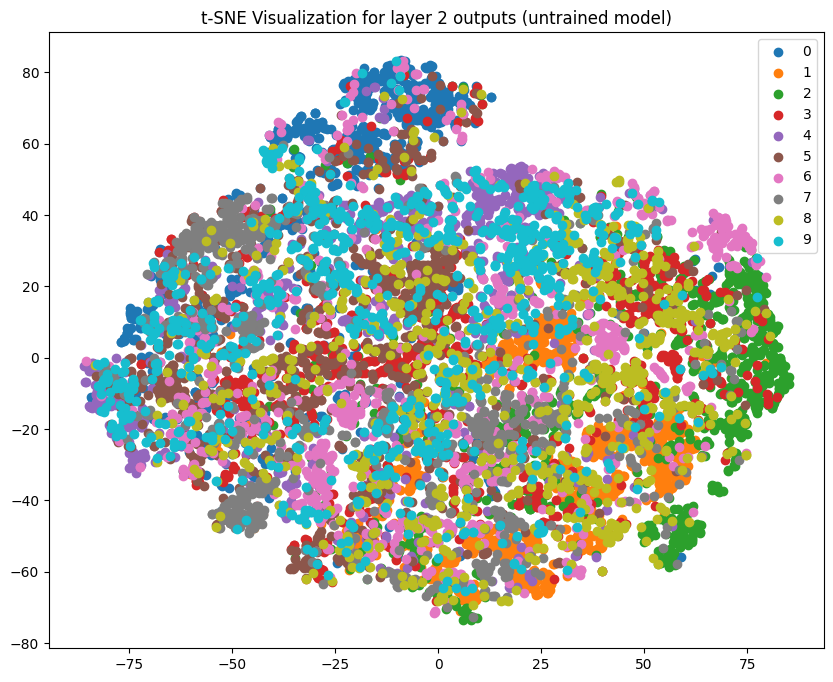

In [106]:
# t-SNE on output of layer 2 of untrained model:
with torch.no_grad():
    y_layer2_untrained = model(X_test.to(device))[1].cpu().numpy()
    # print device of y_layer2_untrained

tsne_untrained = TSNE(n_components=2)
tsne_outputs_untrained = tsne_untrained.fit_transform(y_layer2_untrained)

# Plot t-SNE for the untrained model
plt.figure(figsize=(10, 8))
for i in range(10):
    plt.scatter(tsne_outputs_untrained[y_test == i][:, 0],
                tsne_outputs_untrained[y_test == i][:, 1], label=str(i))
plt.title('t-SNE Visualization for layer 2 outputs (untrained model)')
plt.legend()
plt.show()

In [107]:
# Training the model
import time
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.01)
# Mini-batch training
batch_size = 1000
print_every = 100
elapsed_time = []
for epoch in range(2000):
    start_time = time.time()
    for i in range(0, X_train.shape[0], batch_size):
        x = X_train[i:i+batch_size].to(device)
        y = y_train[i:i+batch_size].to(device)
        y_pred = model(x)[0]
        loss = loss_fn(y_pred, y)
        loss.backward()
        opt.step()
        opt.zero_grad()
    end_time = time.time()
    elapsed_time.append(end_time - start_time)
    if epoch % print_every == 0:
        print(epoch, loss.item())

100 1.236411213874817
200 0.12601177394390106
300 0.13427235186100006
400 0.14236761629581451
500 0.15128041803836823
600 0.13771121203899384
700 0.12094663828611374
800 0.13181152939796448
900 0.12637072801589966
1000 0.11834309995174408
1100 0.12277814000844955
1200 0.1224949061870575
1300 0.12117161601781845
1400 0.11225491017103195
1500 0.12104093283414841
1600 0.13112983107566833
1700 0.13701651990413666
1800 0.12796558439731598
1900 0.1127808690071106
2000 0.13296283781528473


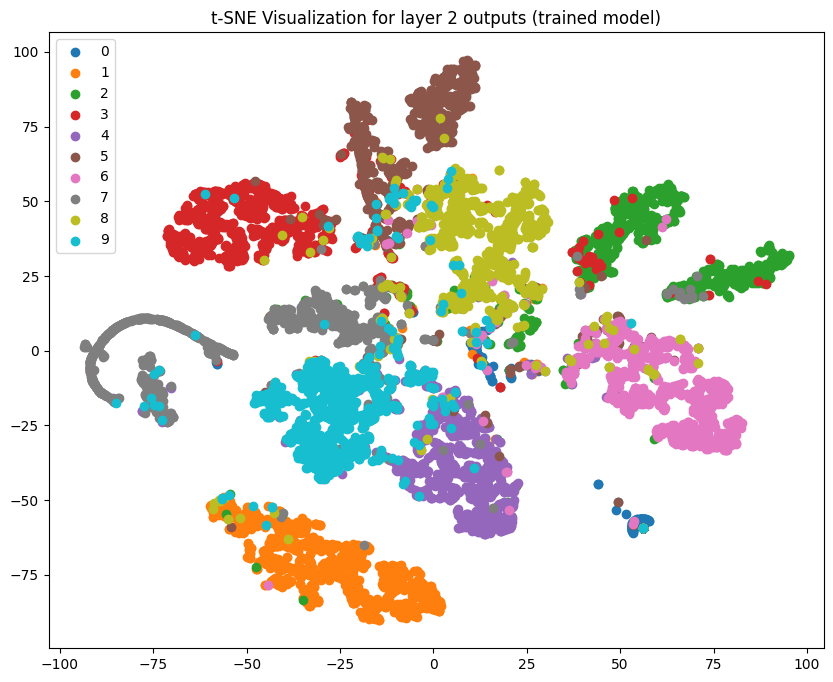

In [108]:
# t-SNE on output of layer 2 of trained model:
with torch.no_grad():
    y_layer2_trained = model(X_test.to(device))[1].cpu().numpy()
    # print device of y_layer2_untrained

tsne_trained = TSNE(n_components=2)
tsne_outputs_trained = tsne_trained.fit_transform(y_layer2_trained)

# Plot t-SNE for the trained model
plt.figure(figsize=(10, 8))
for i in range(10):
    plt.scatter(tsne_outputs_trained[y_test == i][:, 0],
                tsne_outputs_trained[y_test == i][:, 1], label=str(i))
plt.title('t-SNE Visualization for layer 2 outputs (trained model)')
plt.legend()
plt.show()

F1 Score: 0.9127722944286392
Confusion Matrix:


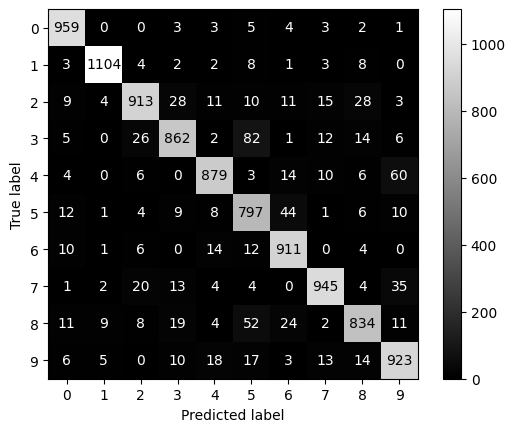

In [109]:
with torch.no_grad():
    y_odds_mlp = model(X_test.to(device))[0].cpu().numpy()
    y_pred_mlp = torch.max(torch.from_numpy(y_odds_mlp), 1)[1]
    f1_mlp = f1_score(y_test, y_pred_mlp, average='weighted')
    cm_mlp = confusion_matrix(y_test, y_pred_mlp)
    print(f"F1 Score: {f1_mlp}")
    print("Confusion Matrix:")
    cm_display = ConfusionMatrixDisplay(cm_mlp).plot(
        values_format='d', cmap='gray', ax=plt.gca())

F1 Score: 0.9704722695987773
Confusion Matrix:


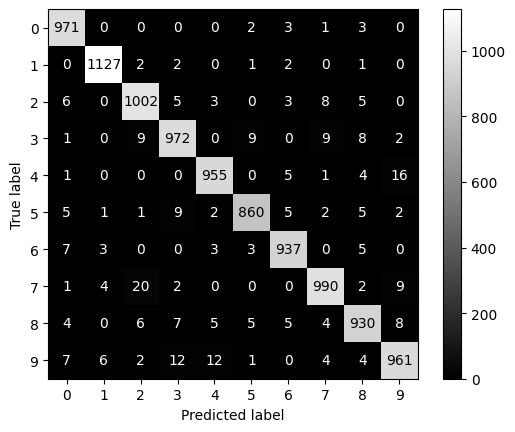

In [110]:
# Random Forrest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
cm_rf = confusion_matrix(y_test, y_pred_rf)

print(f"F1 Score: {f1_rf}")
print("Confusion Matrix:")
cm_display = ConfusionMatrixDisplay(cm_rf).plot(
    values_format='d', cmap='gray', ax=plt.gca())

F1 Score: 0.9209543264763
Confusion Matrix:


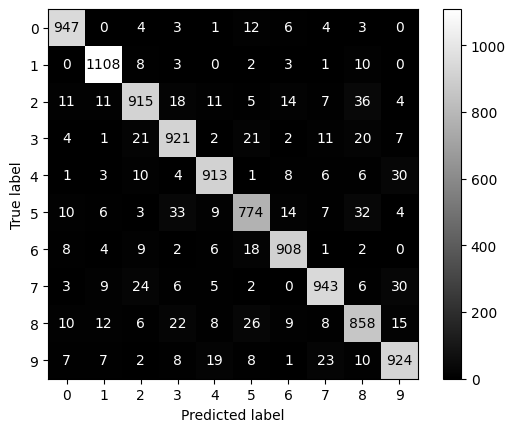

In [111]:
# Logistic Regression
lr_clf = LogisticRegression(max_iter=1000, random_state=42)

lr_clf.fit(X_train_scaled, y_train)
y_pred_lr = lr_clf.predict(X_test_scaled)

f1_lr = f1_score(y_test, y_pred_lr, average='weighted')
cm_lr = confusion_matrix(y_test, y_pred_lr)

print(f"F1 Score: {f1_lr}")
print("Confusion Matrix:")
cm_display = ConfusionMatrixDisplay(cm_lr).plot(values_format='d', cmap='gray', ax=plt.gca())

In [112]:
# Define transformations
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.0,), (0.1,))])

# Download and load MNIST dataset using torchvision
train_dataset_fashion = torchvision.datasets.FashionMNIST(
    root='../datasets', train=True, download=True, transform=transform)
test_dataset_fashion = torchvision.datasets.FashionMNIST(
    root='../datasets', train=False, download=True, transform=transform)

In [113]:
X_train_f = train_dataset_fashion.data.float().reshape(len(train_dataset), -1)
y_train_f = train_dataset_fashion.targets
X_test_f = test_dataset_fashion.data.float().reshape(len(test_dataset), -1)
y_test_f = test_dataset_fashion.targets

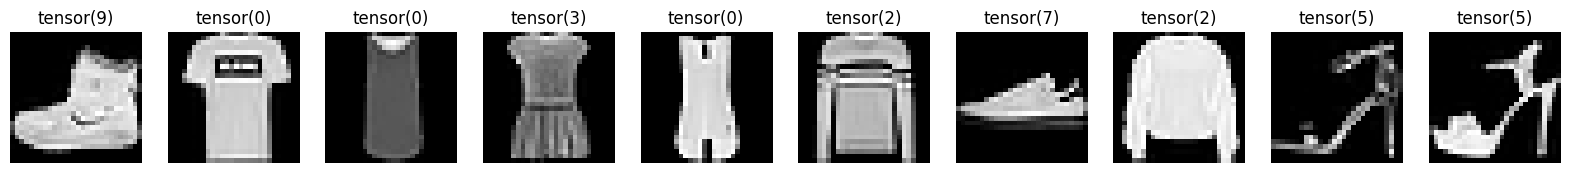

In [114]:
# Plot few images
fig, axs = plt.subplots(1, 10, figsize=(20, 10))
for i in range(10):
    axs[i].imshow(X_train_f[i].reshape((28, 28)), cmap='gray')
    axs[i].set_title(y_train_f[i])
    axs[i].axis('off')

F1 Score: 0.032444325224685724
Confusion Matrix:


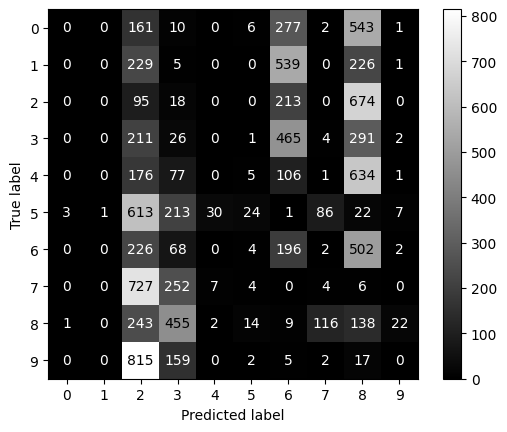

In [115]:
#Running MNIST trained model on Fashion MNIST
with torch.no_grad():
    yf_odds_mlp = model(X_test_f.to(device))[0].cpu().numpy()
    yf_pred_mlp = torch.max(torch.from_numpy(yf_odds_mlp), 1)[1]
    f1_mlp_f = f1_score(y_test_f, yf_pred_mlp, average='weighted')
    cm_mlp_f = confusion_matrix(y_test_f, yf_pred_mlp)
    print(f"F1 Score: {f1_mlp_f}")
    print("Confusion Matrix:")
    cm_display = ConfusionMatrixDisplay(cm_mlp_f).plot(
        values_format='d', cmap='gray', ax=plt.gca())

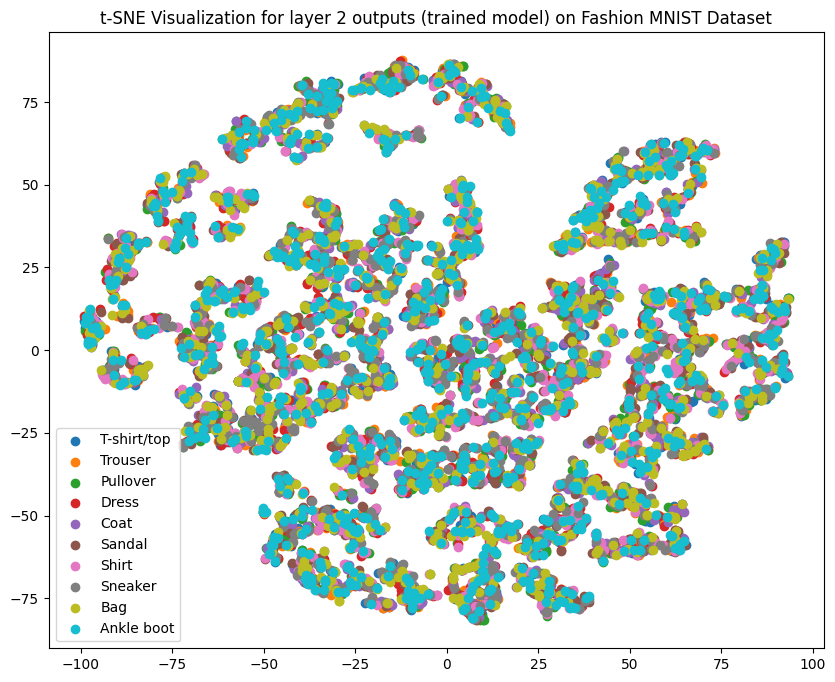

In [116]:
# t-SNE on output of layer 2 of trained model:
with torch.no_grad():
    yf_layer2_trained = model(X_test_f.to(device))[1].cpu().numpy()
    # print device of y_layer2_untrained

tsne_trained = TSNE(n_components=2)
tsne_outputs_trained_f = tsne_trained.fit_transform(yf_layer2_trained)

# Plot t-SNE for the trained model
plt.figure(figsize=(10, 8))
for i in range(10):
    plt.scatter(tsne_outputs_trained_f[y_test == i][:, 0],
                tsne_outputs_trained_f[y_test == i][:, 1], label=str(train_dataset_fashion.classes[i]))
plt.title('t-SNE Visualization for layer 2 outputs (trained model) on Fashion MNIST Dataset')
plt.legend()
plt.show()

#Comparing RF, MLP, Logistic Regression model results:

We can observe that in general RF model gives the highest F1-Score and Logistic Regression and MLP have almost the same F1-Score.

Commonly confused digits are (9, 4), (8, 3), (2, 7).

#Comparing t-SNE plot for trained and untrained model
As expected the untrained model has a scattered t-SNE plot showing that there is absolutely no information given by the 2-dimensional embeddings. But, we can clearly see that the t-SNE plot for the trained model shows somewhat formation of clusters showing that the 2-dimensional embeddings now have some useful information that would help in differentiating the 10 numbers. Moreover, the t-SNE plot of the trained model also gives information about which digits are commonly confused.

#Observations on Fashion MNIST dataset
When we tested the Fashion MNIST dataset on the MNIST trained MLP, it turned out to be a pretty bad model owing to the low F1-score and a confusion matrix showing high misclassification. Also the embeddings for Fashion MNIST show no meaningful cluster formation as compared to that of trained MNIST.